In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from myfunctions import *
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Functions

In [2]:
def extract_feature_basic(data_input, high_corr=True):
    '''
    Input: data is the dataframe with only is_sarcastic and headline column
    Output: data with full features (except headline column)
    '''
    data = data_input.copy()
    data['len_headline'] = data.headline.apply(lambda row: count_word(row)) # count words in title
    data['headline_s1'] = data.headline.apply(lambda row: remove_symbol(row))
    data['len_headline_s1'] = data.headline_s1.apply(lambda row: count_word(row))
    data['count_symbol'] = data.len_headline - data.len_headline_s1
    data['contain_symbol'] = data.count_symbol.apply(lambda row: 1 if row > 0 else 0)
    data['ratio_symbol'] = 1 - data.len_headline_s1/data.len_headline
    data['headline_s2'] = data.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
    data['headline_s2'] = data.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
    data['len_headline_s2'] = data.headline_s2.apply(lambda row: count_word(row))
    data['count_lemmatized'] = count_lemmatized_word(data, 'headline_s1', 'headline_s2')
    data['ratio_lemmatized'] = data['count_lemmatized'] / data['len_headline_s1']
    data['headline_s3'] = data.headline_s2.apply(lambda row: remove_stop_words(row))
    data['len_headline_s3'] = data.headline_s3.apply(lambda row: count_word(row))
    data['numb_stopwords'] = data['len_headline_s2'] - data['len_headline_s3']
    data['ratio_stopwords'] = data['numb_stopwords'] / data['len_headline_s2']
    data['min_len_word'] = data.headline_s1.apply(lambda row: min_len_word(row))
    data['max_len_word'] = data.headline_s1.apply(lambda row: max_len_word(row))
    data['avg_len_word'] = data.headline_s1.apply(lambda row: avg_len_word(row))
    data['has_number'] = data.headline.apply(lambda row: 1 if has_Number(row) else 0)
    data['min_syl_word'] = data.headline_s1.apply(lambda row: min_syl_word(row))
    data['max_syl_word'] = data.headline_s1.apply(lambda row: max_syl_word(row))
    data['avg_syl_word'] = data.headline_s1.apply(lambda row: avg_syl_word(row))
    data['numb_syl'] = data.headline_s1.apply(lambda row: count_syllable(row))
    data['norm_numb_syl'] = data.numb_syl / data.len_headline_s1
    data['numb_lex'] = data.headline_s1.apply(lambda row: count_lexicon(row))
    data['norm_numb_lex'] = data.numb_lex / data.len_headline_s1
    data['flesch_reading_score'] = data.headline.apply(lambda row: textstat.flesch_reading_ease(row))
    data['flesch_grade_score'] = data.headline.apply(lambda row: textstat.flesch_kincaid_grade(row))
    data['fog_score'] = data.headline.apply(lambda row: textstat.gunning_fog(row))
    # data['smog_score'] = data.headline.apply(lambda row: textstat.smog_index(row))
    data['ari_score'] = data.headline.apply(lambda row: textstat.automated_readability_index(row))
    data['coleman_score'] = data.headline.apply(lambda row: textstat.coleman_liau_index(row))
    data['linsear_score'] = data.headline.apply(lambda row: textstat.linsear_write_formula(row))
    data['dale_score'] = data.headline.apply(lambda row: textstat.dale_chall_readability_score(row))
    data['standard_score'] = data.headline.apply(lambda row: textstat.text_standard(row, float_output=True))
    data['numb_NN'] = data.headline.apply(lambda row: count_noun(row))
    data['numb_VED'] = data.headline.apply(lambda row: count_verb_past(row))
    data['numb_VB'] = data.headline.apply(lambda row: count_verb_present(row))
    data['numb_VING'] = data.headline.apply(lambda row: count_verb_ing(row))
    data['numb_ADJ'] = data.headline.apply(lambda row: count_adj(row))
    data['numb_ADV'] = data.headline.apply(lambda row: count_adv(row))
    data['numb_DT'] = data.headline.apply(lambda row: count_DT(row))
    data['numb_CD'] = data.headline.apply(lambda row: count_CD(row))
    data['numb_PR'] = data.headline.apply(lambda row: count_pronoun(row))
    data['norm_numb_NN'] = data['numb_NN'] / data['len_headline']
    data['norm_numb_VED'] = data['numb_VED'] / data['len_headline']
    data['norm_numb_VB'] = data['numb_VB'] / data['len_headline']
    data['norm_numb_VING'] = data['numb_VING'] / data['len_headline']
    data['norm_numb_ADJ'] = data['numb_ADJ'] / data['len_headline']
    data['norm_numb_ADV'] = data['numb_ADV'] / data['len_headline']
    data['norm_numb_DT'] = data['numb_DT'] / data['len_headline']
    data['norm_numb_CD'] = data['numb_CD'] / data['len_headline']
    data['norm_numb_PR'] = data['numb_PR'] / data['len_headline']
    data['depth_syntree'] = data.headline_s1.apply(lambda row: get_depth_syntax_tree(row))
    data['norm_depth_syntree'] = data['depth_syntree'] / data.len_headline_s1
    
    data['preprocess_headline'] = data.headline.apply(lambda row: preprocess_sent(row, remove_stopwords=False))
    all_string = data.preprocess_headline.tolist()
    all_string_in_one = ' '.join(all_string)
    list_common_words,_ = most_common_words(all_string_in_one, numb_words=11)
    data['norm_common_words'] = data.preprocess_headline.apply(lambda row: numb_common_words(row, list_common_words, norm=True))
    
    if high_corr:
        list_ft = data.columns.tolist()
        keep_ft = ['is_sarcastic', 'ratio_stopwords', 'avg_len_word', 'avg_syl_word', 'norm_numb_syl',
                   'flesch_reading_score', 'flesch_grade_score', 'ari_score', 'coleman_score', 'linsear_score', 
                   'standard_score', 'norm_numb_ADJ', 'norm_numb_ADV', 'norm_numb_DT', 'norm_common_words']
        discard_ft = [x for x in list_ft if x not in keep_ft]
    else:
        discard_ft = ['headline', 'headline_s1', 'headline_s2', 'headline_s3', 'preprocess_headline']
    data_ft = data.drop(columns=discard_ft)
    
    if high_corr:
        # dis flesch reading score (-0.97 wtih flesch grade score)
        # dis norm_numb_syl (0.99 with avg_syl_word)
        data_ft = data_ft.drop(columns=['norm_numb_syl', 'flesch_reading_score'])
    
    return data_ft

## Read and Split Data

In [3]:
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

In [4]:
# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

===== TRAINING SAMPLES =====
Total Sample: 18316
Sarcastic: 8726 (47.64%)
Not Sarcastic: 9590 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4579
Sarcastic: 2181 (47.63%)
Not Sarcastic: 2398 (52.37%)
===== TESTING SAMPLES =====
Total Sample: 5724
Sarcastic: 2727 (47.64%)
Not Sarcastic: 2997 (52.36%)


## Extract Features

In [5]:
high_corr = False
print('Extract Features Training ...')
data_train_ft = extract_feature_basic(df_train, high_corr=high_corr)
print('Extract Features Training Full...')
data_train_f_ft = extract_feature_basic(df_train_f, high_corr=high_corr)
print('Extract Features Validating ...')
data_validate_ft = extract_feature_basic(df_validate, high_corr=high_corr)

Extract Features Training ...
Extract Features Training Full...
Extract Features Validating ...


In [6]:
# dis flesch reading score (-0.97 wtih flesch grade score)
# dis norm_numb_syl (0.99 with avg_syl_word)
# dis len_headline, len_headline_s1, len_headline_s2
# dis count_symbol 
# dis norm numb syl

dis_col = ['flesch_reading_score', 'norm_numb_syl', 'len_headline', 
           'len_headline_s1', 'len_headline_s2', 'count_symbol', 'norm_numb_syl']

data_train_ft = data_train_ft.drop(columns=dis_col)
data_train_f_ft = data_train_f_ft.drop(columns=dis_col)
data_validate_ft = data_validate_ft.drop(columns=dis_col)

### Correlation between Features
Here we will remove features having high correlation to others. We will keep the one having higher correlation with the outcome.

In [7]:
# a = data_train_f_ft.corr()
# a.iloc[:, 10:30]

### Concert to Numpy array

In [8]:
X_train_f = data_train_f_ft.drop(columns=['is_sarcastic'])
y_train_f = data_train_f_ft['is_sarcastic']
X_train_f = np.asarray(X_train_f)
y_train_f = np.asarray(y_train_f)

X_train = data_train_ft.drop(columns=['is_sarcastic'])
y_train = data_train_ft['is_sarcastic']
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_validate = data_validate_ft.drop(columns=['is_sarcastic'])
y_validate = data_validate_ft['is_sarcastic']
X_validate = np.asarray(X_validate)
y_validate = np.asarray(y_validate)

feature_names = list(data_validate_ft.drop(columns=['is_sarcastic']).columns)

## RF Model
Since RF support bagging method, we do not need to use validate set distinctly. We will train both train and validate set together

### GridSearch

In [13]:
hypara = {
    'max_depth': [15, 20, 25, 30],
    'n_estimators': [250, 300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

In [14]:
model_cv_rf = GridSearchCV(RandomForestClassifier(), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 10.6min finished


Best OOB Score: 0.7273640532867438
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [11]:
# For Fun
# validate_pred = model_cv_rf.predict_proba(X_validate)
# validate_pred = validate_pred[:,1]
# metrics = calculate_metric(y_validate, validate_pred)
# metrics

### Train again

In [15]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 300,
    'min_samples_split': 7,
    'min_samples_leaf': 2,
}

hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 300,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);

In [16]:
validate_pred = model_rf.predict_proba(X_validate)
validate_pred = validate_pred[:,1]
metrics = calculate_metric(y_validate, validate_pred)
metrics

{'accuracy': 0.7150032758244158,
 'precision': 0.6938053097345133,
 'recall': 0.7189362677670793,
 'f1': 0.7061472641297005,
 'tp': 1568,
 'tn': 1706,
 'fp': 692,
 'fn': 613,
 'auc': 0.8045863146692243}

### Feature Importance

In [17]:
result = permutation_importance(model_rf, X_train, y_train, n_repeats=10,
                                random_state=1509, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

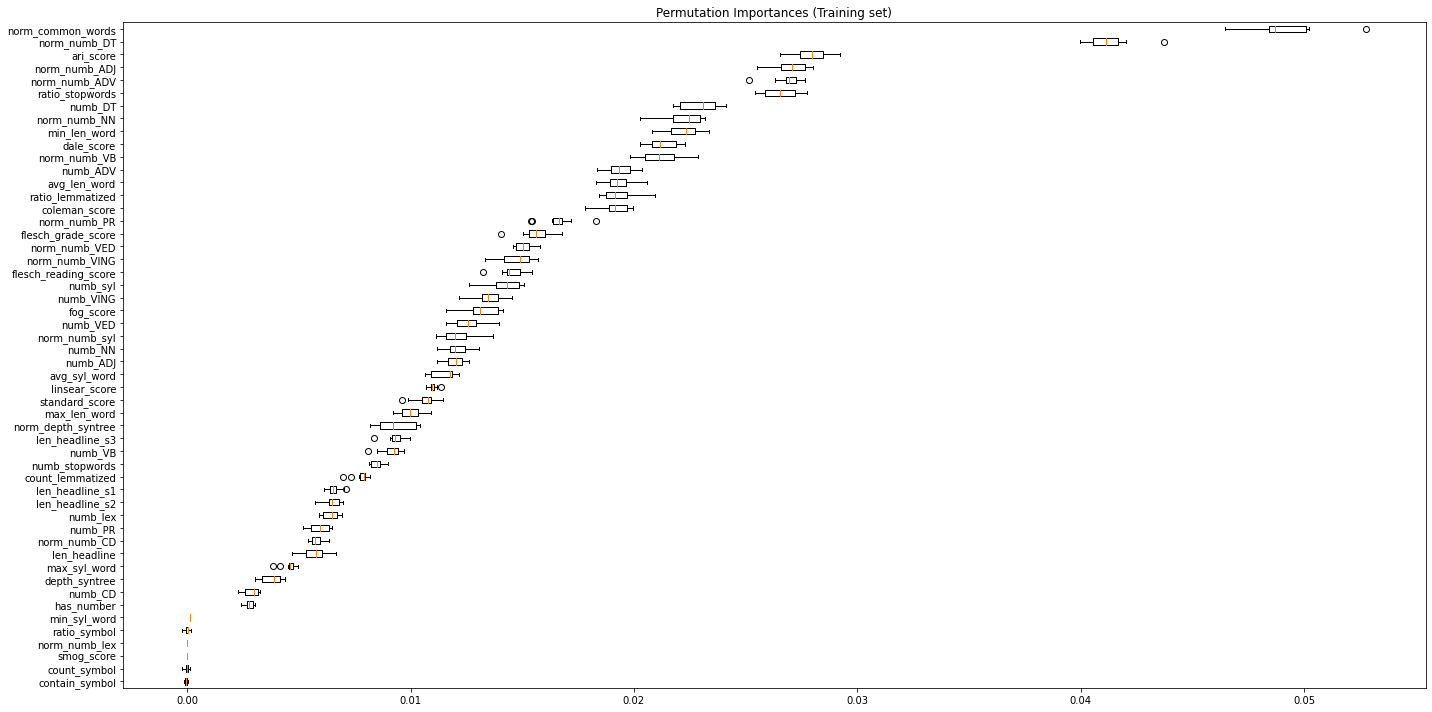

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.asarray(feature_names)[sorted_idx])
ax.set_title("Permutation Importances (Training set)")
fig.tight_layout()
plt.show()

## SVM

### Train Again

In [18]:
# SVM need normalization
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_validate_norm = scaler.transform(X_validate)

In [19]:
hypara = {
    'C': [0.1, 1, 5, 10],
}

model_cv_svm = GridSearchCV(SVC(max_iter=100000, tol=1e-5), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.5min finished


Best CV Score: 0.7280192181699062
Best paras: {'C': 10}


In [23]:
hypara = {
    'C': 100,
    'random_state': 1509,
    'max_iter':100000,
    'tol' : 1e-5
}
model_svm = SVC(**hypara)
model_svm.fit(X_train_norm, y_train);

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [21]:
# validate_pred = model_svm.predict_proba(X_validate)
# validate_pred = validate_pred[:,1]
validate_pred = model_svm.predict(X_validate_norm)
metrics = calculate_metric(y_validate, validate_pred)
metrics

{'accuracy': 0.7278881851932737,
 'precision': 0.7080551846906987,
 'recall': 0.729481889041724,
 'f1': 0.7186088527551941,
 'tp': 1591,
 'tn': 1742,
 'fp': 656,
 'fn': 590,
 'auc': 0.7279602939787436}

## Logistic Regression

In [25]:
hypara = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-5, solver='saga'), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.4min finished


Best CV Score: 0.7011137803013758
Best paras: {'C': 5, 'penalty': 'l1'}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [21]:
scaler = StandardScaler().fit(X_train_f)
X_train_f_norm = scaler.transform(X_train_f)

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-5, solver='saga'), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f_norm, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished


Best CV Score: 0.6671762393535707
Best paras: {'C': 1, 'penalty': 'l2'}


In [26]:
hypara = {
    'penalty': 'l1',
    'C': 5,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'saga'
}

hypara = {
    'penalty': 'l1',
    'C': 5,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'saga'
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);
validate_pred = model_lr.predict_proba(X_validate)
validate_pred = validate_pred[:,1]
metrics = calculate_metric(y_validate, validate_pred)
metrics

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'accuracy': 0.7043022493994322,
 'precision': 0.683370288248337,
 'recall': 0.7065566254011921,
 'f1': 0.6947700631199278,
 'tp': 1541,
 'tn': 1684,
 'fp': 714,
 'fn': 640,
 'auc': 0.7679525464250929}

## Naive Bayes

In [28]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

GaussianNB()

In [29]:
validate_pred = model_nb.predict_proba(X_validate)
validate_pred = validate_pred[:,1]
metrics = calculate_metric(y_validate, validate_pred)
metrics

{'accuracy': 0.6440270801485041,
 'precision': 0.5838660578386605,
 'recall': 0.8794131132508024,
 'f1': 0.7017929015733626,
 'tp': 1918,
 'tn': 1031,
 'fp': 1367,
 'fn': 263,
 'auc': 0.7332316705920683}

## KNN

### Grid Search

In [31]:
scaler = StandardScaler().fit(X_train_f)
X_train_f_norm = scaler.transform(X_train_f)

hypara = {
    'n_neighbors': [10, 20, 50, 100, 150, 200, 300, 500],
    'weights': ['uniform', 'distance']
}

model_cv_knn = GridSearchCV(KNeighborsClassifier(), hypara, verbose=1, n_jobs=-1)
model_cv_knn.fit(X_train_f_norm, y_train_f);
print(f"Best CV Score: {model_cv_knn.best_score_}")
print(f"Best paras: {model_cv_knn.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished


Best CV Score: 0.7139550120113561
Best paras: {'n_neighbors': 200, 'weights': 'distance'}


### Train Again

In [32]:
hypara = {
    'n_neighbors': 200,
    'weights': 'distance'
}
model_knn = KNeighborsClassifier(**hypara)
model_knn.fit(X_train_norm, y_train);

validate_pred = model_knn.predict_proba(X_validate_norm)
validate_pred = validate_pred[:,1]
metrics = calculate_metric(y_validate, validate_pred)
metrics

{'accuracy': 0.7147848875300284,
 'precision': 0.6982328953330312,
 'recall': 0.7065566254011921,
 'f1': 0.7023701002734731,
 'tp': 1541,
 'tn': 1732,
 'fp': 666,
 'fn': 640,
 'auc': 0.7939601968475183}

## MLP

### GridSearch

In [34]:
hypara = {
    'hidden_layer_sizes': [(16,), (32,), (32, 8,), (64, 8,)],
    'learning_rate_init': [0.005, 0.001],
    
}

model_cv_mlp = GridSearchCV(MLPClassifier(max_iter=1000), hypara, verbose=1, n_jobs=-1)
model_cv_mlp.fit(X_train_f_norm, y_train_f);
print(f"Best OOB Score: {model_cv_mlp.best_score_}")
print(f"Best paras: {model_cv_mlp.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best OOB Score: 0.7378903690762175
Best paras: {'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001}


### Train Again

In [35]:
hypara = {
    'hidden_layer_sizes': (16,),
    'learning_rate_init': 0.005,
    'max_iter': 1000,
    'random_state': 1509
}

hypara = {
    'hidden_layer_sizes': (16,),
    'learning_rate_init': 0.001,
    'max_iter': 1000,
    'random_state': 1509
}
model_mlp = MLPClassifier(**hypara)
model_mlp.fit(X_train_norm, y_train);

validate_pred = model_mlp.predict_proba(X_validate_norm)
validate_pred = validate_pred[:,1]
metrics = calculate_metric(y_validate, validate_pred)
metrics

{'accuracy': 0.7340030574361214,
 'precision': 0.7137150466045273,
 'recall': 0.7372764786795049,
 'f1': 0.7253044654939108,
 'tp': 1608,
 'tn': 1753,
 'fp': 645,
 'fn': 573,
 'auc': 0.8162416793147584}

### Implementation

In [36]:
from deep_pytorch import *

In [39]:
X_train.shape

(18316, 45)

In [37]:
pt_train = pd.DataFrame(np.hstack((y_train.reshape(18316, 1), X_train_norm)), columns=data_train_ft.columns.tolist())
pt_validate = pd.DataFrame(np.hstack((y_validate.reshape(X_validate_norm.shape[0], 1), X_validate_norm)), columns=data_train_ft.columns.tolist())

In [38]:
datasetTrain = EncodingDataset(pt_train)
datasetVal = EncodingDataset(pt_validate)

In [42]:
model_mlp = ModelMLP(datasetTrain=datasetTrain, datasetVal=datasetVal, batch_size=1024, optimizer_choice='adam', 
                     init_lr=0.001, layers=[45, 16, 1], dropout=0.25, batchnorm=True, checkpoint=None)
model_mlp.train()

TRAIN FROM SCRATCH
Training 0/99
Total iteration: 18
Epoch 1/100 [01122020-012346] [SAVE]
AccVal: 0.5752347674164665
AUCVal: 0.6574746684440915
Precision: 0.5357142686843872
Recall: 0.8115543127059937
F1Val: 0.6453965172709341
LossVal: 0.6733203172683716
LossTrain: 0.7044986055956947
----------

Training 1/99
Total iteration: 18
Epoch 2/100 [01122020-012350] [SAVE]
AccVal: 0.6398777025551431
AUCVal: 0.7084399769179497
Precision: 0.5996254682540894
Recall: 0.7340669631958008
F1Val: 0.6600700973576417
LossVal: 0.640235435962677
LossTrain: 0.6575232214397855
----------

Training 2/99
Total iteration: 18
Epoch 3/100 [01122020-012355] [SAVE]
AccVal: 0.6721991701244814
AUCVal: 0.7339574779380188
Precision: 0.6420217156410217
Recall: 0.7047225832939148
F1Val: 0.6719125558357987
LossVal: 0.618685519695282
LossTrain: 0.630716817246543
----------

Training 3/99
Total iteration: 18
Epoch 4/100 [01122020-012400] [SAVE]
AccVal: 0.6802795370168159
AUCVal: 0.7473364438269856
Precision: 0.656073153018

Epoch 31/100 [01122020-012610] [SAVE]
AccVal: 0.7195894300065516
AUCVal: 0.7969549169623624
Precision: 0.7079277038574219
Recall: 0.7001375555992126
F1Val: 0.7040110503540185
LossVal: 0.5457238554954529
LossTrain: 0.5430084268252054
----------

Training 31/99
Total iteration: 18
Epoch 32/100 [01122020-012615] [SAVE]
AccVal: 0.7198078183009391
AUCVal: 0.7973903822496127
Precision: 0.7069124579429626
Recall: 0.7033470869064331
F1Val: 0.7051252953008986
LossVal: 0.5452723145484925
LossTrain: 0.5397571755780114
----------

Training 32/99
Total iteration: 18
Epoch 33/100 [01122020-012620] [SAVE]
AccVal: 0.7211181480672636
AUCVal: 0.7979355025718743
Precision: 0.7088724374771118
Recall: 0.7033470869064331
F1Val: 0.7060989531431785
LossVal: 0.5450780749320984
LossTrain: 0.5396080613136292
----------

Training 33/99
Total iteration: 18
Epoch 34/100 [01122020-012624] [SAVE]
AccVal: 0.7191526534177768
AUCVal: 0.7983166661504181
Precision: 0.7076566219329834
Recall: 0.6992205381393433
F1Val: 0.70

Epoch 61/100 [01122020-012832] [SAVE]
AccVal: 0.7274514086044988
AUCVal: 0.8079426956362459
Precision: 0.7135011553764343
Recall: 0.7148097157478333
F1Val: 0.7141548361372186
LossVal: 0.5353394389152527
LossTrain: 0.5295721722973717
----------

Training 61/99
Total iteration: 18
Epoch 62/100 [01122020-012837] [SAVE]
AccVal: 0.7276697968988862
AUCVal: 0.8077717599757401
Precision: 0.7152073979377747
Recall: 0.7116001844406128
F1Val: 0.7133992015608557
LossVal: 0.5355554461479187
LossTrain: 0.529219690296385
----------

Training 62/99
Total iteration: 18
Epoch 63/100 [01122020-012841] [SAVE]
AccVal: 0.7278881851932737
AUCVal: 0.8079476669194373
Precision: 0.714154839515686
Recall: 0.7148097157478333
F1Val: 0.714482097768732
LossVal: 0.5353543996810913
LossTrain: 0.5285996927155389
----------

Training 63/99
Total iteration: 18
Epoch 64/100 [01122020-012846]
AccVal: 0.7276697968988862
AUCVal: 0.8081134400935519
Precision: 0.7156047821044922
Recall: 0.7106831669807434
F1Val: 0.713135512968

Epoch 90/100 [01122020-013046]
AccVal: 0.732255951081022
AUCVal: 0.8111103590451925
Precision: 0.7205542922019958
Recall: 0.7152682542800903
F1Val: 0.7179015726633347
LossVal: 0.5321386933326722
LossTrain: 0.5265155732631683
----------

Training 90/99
Total iteration: 18
Epoch 91/100 [01122020-013051] [SAVE]
AccVal: 0.7316007861978598
AUCVal: 0.8111791921970739
Precision: 0.720370352268219
Recall: 0.7134342193603516
F1Val: 0.7168855385945978
LossVal: 0.5320783376693725
LossTrain: 0.5249438881874084
----------

Training 91/99
Total iteration: 18
Epoch 92/100 [01122020-013055] [SAVE]
AccVal: 0.7320375627866347
AUCVal: 0.8111925764210508
Precision: 0.7210379838943481
Recall: 0.7134342193603516
F1Val: 0.7172159488370213
LossVal: 0.532046127319336
LossTrain: 0.5259524683157603
----------

Training 92/99
Total iteration: 18
Epoch 93/100 [01122020-013100]
AccVal: 0.732255951081022
AUCVal: 0.8111006076820092
Precision: 0.7213722467422485
Recall: 0.7134342193603516
F1Val: 0.717381274592022
Loss